In [4]:
import pandas as pd
import os
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

import boto3
import sagemaker


In [2]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

In [6]:
# set locations from variables from data preperation notebook
train_location = 's3://sagemaker-us-east-1-517714493426/anomaly/train.csv'
val_location = 's3://sagemaker-us-east-1-517714493426/anomaly/val.csv'
test_location = 's3://sagemaker-us-east-1-517714493426/anomaly/test.csv'

## Train a Model with Sagemaker built-in function Random Cut Forests


Common Data Formats for Training
RCF
- x-recordio-protobuf
- csv

Example of using x-redio-protobuf: 
https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/factorization_machines_mnist/factorization_machines_mnist.html


https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/random_cut_forest/random_cut_forest.html


In [9]:
import sagemaker

prefix = 'anomaly'
region = sagemaker.Session().boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

#https://docs.aws.amazon.com/sagemaker/latest/dg/ecr-us-east-1.html#randomcutforest-us-east-1.title
container=sagemaker.image_uris.retrieve("randomcutforest", region, "us-east-1")
print(container)

rcf = sagemaker.estimator.Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    sagemaker_session=sagemaker.Session(),
    instance_type="ml.m4.xlarge",
    #data_location=f"s3://{bucket}/{prefix}/",
    output_path=f"s3://{bucket}/{prefix}/output"
)

rcf.set_hyperparameters(
    feature_dim = 75,
    eval_metrics = 'precision_recall_fscore',
    num_samples_per_tree=256,
    num_trees=100,
    
)

train_data = sagemaker.inputs.TrainingInput(s3_data=train_location, content_type='text/csv;label_size=0', distribution='ShardedByS3Key')
test_data = sagemaker.inputs.TrainingInput(s3_data=test_location, content_type='text/csv;label_size=1', distribution='FullyReplicated')


rcf.fit({'train': train_data, 'test': test_data}, wait=True)

AWS Region: us-east-1


Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: us-east-1.


RoleArn: arn:aws:iam::517714493426:role/service-role/AmazonSageMaker-ExecutionRole-20210409T152960
382416733822.dkr.ecr.us-east-1.amazonaws.com/randomcutforest:1
2021-08-03 07:37:03 Starting - Starting the training job...
2021-08-03 07:37:26 Starting - Launching requested ML instancesProfilerReport-1627976223: InProgress
......
2021-08-03 07:38:27 Starting - Preparing the instances for training.........
2021-08-03 07:40:49 Downloading - Downloading input data
2021-08-03 07:40:49 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[08/03/2021 07:40:54 INFO 140449074038592] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'num_samples_per_tree': 256, 'num_trees': 100, 'force_dense': 'true', 'eval_metrics': ['accuracy', 'precision_recall_fscore'], 'epochs': 1, 'mini_batch_size': 1000, '_log_level': 'info', '_kvst

In [16]:
# logs files say, that there are no anomalous data in test_data, but this isn't true:

import pandas as pd
import s3fs

df = pd.read_csv('s3://sagemaker-us-east-1-517714493426/anomaly/test.csv')

In [14]:
df

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,74,75
0,1,-0.159794,-0.003459,-0.088065,-0.003324,0.0,-0.003324,-0.052409,-0.009234,-1.598381,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,-0.159794,-0.033869,-0.088065,-0.003324,0.0,-0.003324,-0.052409,-0.009234,-1.598381,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,-0.159794,-0.003459,-0.088065,-0.003324,0.0,-0.003324,-0.052409,-0.009234,-1.598381,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,-0.159794,-0.003459,-0.088065,-0.003324,0.0,-0.003324,-0.052409,-0.009234,-1.598381,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,-0.159794,-0.003459,-0.088065,-0.003324,0.0,-0.003324,-0.052409,-0.009234,-1.598381,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17286,1,-0.159794,-0.033869,-0.088065,-0.003324,0.0,-0.003324,-0.052409,-0.009234,-1.598381,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17287,1,-0.159794,-0.003459,-0.088065,-0.003324,0.0,-0.003324,-0.052409,-0.009234,-1.598381,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17288,0,-0.145198,-0.027121,-0.068596,-0.003324,0.0,-0.003324,4.573175,-0.009234,0.625633,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17289,1,-0.159794,-0.003459,-0.088065,-0.003324,0.0,-0.003324,-0.052409,-0.009234,-1.598381,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Make predictions

In [10]:
print(f"Training job name: {rcf.latest_training_job.job_name}")

Training job name: randomcutforest-2021-08-03-07-37-03-247


In [11]:
data_dir = 'data'
prefix = 'anomaly'
test_data_without_label = pd.read_pickle('X_test.pkl')
test_data_without_label.to_csv(os.path.join(data_dir, 'test_without_label.csv'), header=False, index=False)
test_without_label_location = sagemaker_session.upload_data(os.path.join(data_dir, 'test_without_label.csv'), key_prefix=prefix)

In [12]:
rcf_transformer = rcf.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

# TODO: Start the transform job. Make sure to specify the content type and the split type of the test data.
rcf_transformer.transform(test_without_label_location, content_type='text/csv', split_type='Line')
rcf_transformer.wait()

.................................
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[08/03/2021 07:47:23 INFO 140093828929344] loaded entry point class algorithm.serve.server_config:config_api
[08/03/2021 07:47:23 INFO 140093828929344] loading entry points
[08/03/2021 07:47:23 INFO 140093828929344] Loaded iterator creator application/x-recordio-protobuf for content type ('application/x-recordio-protobuf', '1.0')
[08/03/2021 07:47:23 INFO 140093828929344] loaded request iterator application/json
[08/03/2021 07:47:23 INFO 140093828929344] loaded request iterator application/jsonlines
[08/03/2021 07:47:23 INFO 140093828929344] loaded request iterator application/x-recordio-protobuf
[08/03/2021 07:47:23 INFO 140093828929344] loaded request iterator text/csv
[08/03/2021 07:47:23 INFO 140093828929344] loaded response encoder application/json
[08/03/2021 07:47:23 INFO 140093828929344] loaded response encoder application/jsonlines
[08/03/2021 07:

## Analyzing results and set treshold

In [13]:
data_dir = 'output_rcf'
# copy result on S3 to local notebook instance
!aws s3 cp --recursive $rcf_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-517714493426/randomcutforest-2021-08-03-07-41-59-072/test_without_label.csv.out to output_rcf/test_without_label.csv.out


In [14]:
predictions_raw = pd.read_csv(os.path.join(data_dir, 'test_without_label.csv.out'), sep=",", header=None)
print(predictions_raw)

                            0
0      {"score":3.1097406287}
1      {"score":0.7819168273}
2      {"score":3.1097406287}
3      {"score":3.1097406287}
4      {"score":3.1097406287}
...                       ...
17286  {"score":1.9456657518}
17287  {"score":3.1097406287}
17288  {"score":1.8871700176}
17289  {"score":3.1097406287}
17290  {"score":5.2619470865}

[17291 rows x 1 columns]


In [15]:
def get_scores(predictions):
    pred = np.empty(predictions.shape[0])
    
    for i in range(predictions.shape[0]):
        pred[i] = predictions.iloc[i][0].split(":",1)[1][:-1]
        
    return pred

In [16]:
pred = get_scores(predictions_raw)

In [17]:
pred_df = pd.DataFrame(pred)
pred_df.describe()

,0
count,17291.000000
mean,2.904955
std,1.461934
min,0.297575
25%,2.369562
50%,3.109741
75%,3.109741
max,5.291201


<AxesSubplot:xlabel='Anomaly Score', ylabel='Frequency'>

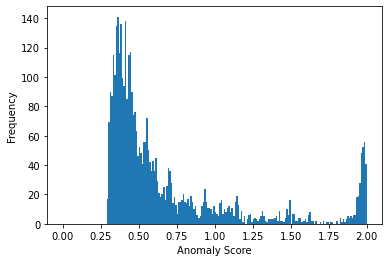

In [18]:
#distribution
import matplotlib.pyplot as plt
plt.xlabel('Anomaly Score')
pred_df[0].plot.hist(bins=200, range=[0, 2])

In [19]:
y_test = pd.read_pickle("y_test.pkl")
y_test = pd.DataFrame({'label': y_test, 'score': pred})

In [20]:
y_test

,label,score
490108,1,3.109741
349249,0,0.781917
489873,1,3.109741
132142,1,3.109741
259390,1,3.109741
...,...,...
464458,1,1.945666
177079,1,3.109741
148781,0,1.887170
273230,1,3.109741


In [21]:
y_test.groupby(by='label').describe()

score                                                              \
         count      mean       std       min       25%       50%       75%   
label                                                                        
0       3409.0  0.565892  0.336600  0.297575  0.377576  0.454806  0.613906   
1      13882.0  3.479358  0.980149  0.544002  3.109722  3.109741  3.109741   

                 
            max  
label            
0      3.932158  
1      5.291201

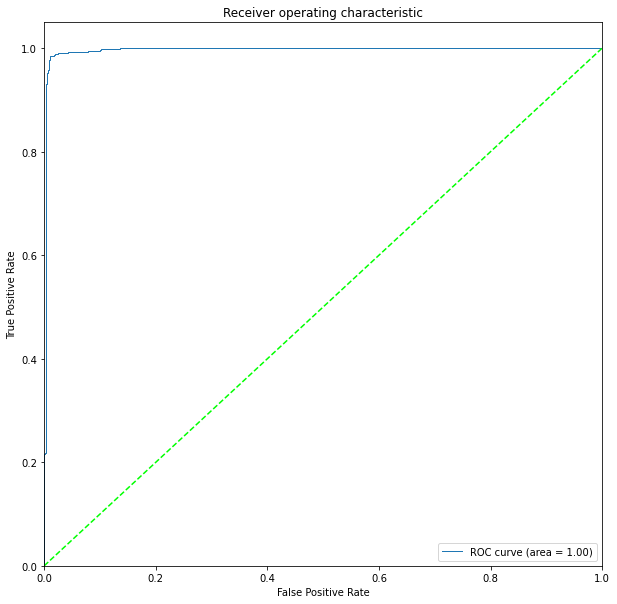

In [22]:
fpr, tpr, thresholds = roc_curve(y_test['label'].values, y_test['score'].values)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='lime', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Hyperparameter Tuning

In [12]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

prefix = 'anomaly'
region = sagemaker.Session().boto_region_name
container=sagemaker.image_uris.retrieve("randomcutforest", region, "us-east-1")

rcf = sagemaker.estimator.Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    sagemaker_session=sagemaker.Session(),
    instance_type="ml.m4.xlarge",
    #data_location=f"s3://{bucket}/{prefix}/",
    output_path=f"s3://{bucket}/{prefix}/output"
)

rcf.set_hyperparameters(
    feature_dim = 75, #If you use the Random Cut Forest estimator, this value is calculated for you and need not be specified, but hyperparamer tuner wanted to know this value
    eval_metrics = 'precision_recall_fscore',
    num_samples_per_tree=256,
    num_trees=100,
    
)

#train_data = sagemaker.inputs.TrainingInput(s3_data=train_location, content_type='text/csv;label_size=0', distribution='ShardedByS3Key')
#val_data = sagemaker.inputs.TrainingInput(s3_data=val_location, content_type='text/csv;label_size=1', distribution='FullyReplicated')

train_data = sagemaker.inputs.TrainingInput(s3_data=train_location, content_type='text/csv;label_size=0', distribution='ShardedByS3Key')
test_data = sagemaker.inputs.TrainingInput(s3_data=test_location, content_type='text/csv;label_size=1', distribution='FullyReplicated')
val_data = sagemaker.inputs.TrainingInput(s3_data=val_location, content_type='text/csv;label_size=1', distribution='FullyReplicated')


# https://docs.aws.amazon.com/sagemaker/latest/dg/random-cut-forest-tuning.html
rcf_hyperparameter_tuner = HyperparameterTuner(estimator = rcf, # The estimator object to use as the basis for the training jobs.
                                               objective_metric_name = 'test:f1', # The metric used to compare trained models.
                                               objective_type = 'Maximize', # Whether we wish to minimize or maximize the metric.
                                               max_jobs = 6, # The total number of models to train
                                               max_parallel_jobs = 3, # The number of models to train in parallel
                                               hyperparameter_ranges = {
                                                    'num_samples_per_tree': IntegerParameter(100, 2000),
                                                    'num_trees'      : IntegerParameter(50, 800),
                                               })

rcf_hyperparameter_tuner.fit({'train': train_data, 'test': val_data})

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: us-east-1.


............................................................................................................................!


## Inference 

In [ ]:
rcf_inference = rcf.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")
print(f"Endpoint name: {rcf_inference.endpoint}")

In [ ]:
# only work for old sagemaker version
#from sagemaker.predictor import csv_serializer
#
#rcf_inference.content_type = 'text/csv'
#rcf_inference.serializer = csv_serializer

## Data Serialization

In [ ]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

rcf_inference.serializer = CSVSerializer()
rcf_inference.deserializer = JSONDeserializer()

In [ ]:
X_test = pd.read_pickle("X_test.pkl")
y_test = pd.read_pickle("y_test.pkl")

In [ ]:
X_test.values

In [ ]:
#X_test_numpy = X_test.values.to_numpy().reshape(-1, 1)
X_test_numpy = X_test.values.reshape(-1, 1)
#print(X_test_numpy[:6])
results = rcf_inference.predict(
    X_test_numpy, initial_args={"ContentType": "text/csv", "Accept": "application/json"}
)

## Predicion & Anomaly Scores

In [ ]:
results = rcf_inference.predict(X_test_numpy)
scores = [entry["score"] for entry in results["scores"]]

# add scores to taxi data frame and print first few values
y_test_predict = pd.Series(scores, index=X_test.index)
y_test_predict.head()